In [ ]:
#https://plotly.com/python/visualizing-mri-volume-slices/

In [ ]:
#https://stackoverflow.com/questions/73726025/how-could-i-create-a-fps-1-mp4-video-using-ffmpegwriter-from-matplotlib-animatio

In [ ]:
#idea: extract LUT from Nikon elements viewer, take nd2 as numpy array. Plot frame by frame

In [ ]:
# maybe use instead of mpeg, gif: https://stackoverflow.com/questions/753190/programmatically-generate-video-or-animated-gif-in-python

In [ ]:
# IMPORTANT: https://stackoverflow.com/questions/30965355/speedup-matplotlib-animation-to-video-file

# Play two videos in parallel, below them time series with sliding vertical bar matching current frame of videos

In [1]:
#Auto-reload modules (used to develop functions outside this notebook)
%load_ext autoreload
%autoreload 2

In [97]:
import labrotation.file_handling as fh
from labrotation.two_photon_session import TwoPhotonSession as TPS
from nd2_to_caiman import np_arr_from_nd2, np_arr_and_time_stamps_from_nd2
import numpy as np
import matplotlib.pylab as plt
import matplotlib.animation as animation
import subprocess
import csv
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib import pyplot

In [3]:
ts_left_fname = fh.open_file("Open data for left time series plot")
ts_right_fname = fh.open_file("Open data for right time series plot")

In [4]:
video_left = fh.open_file("Select nd2 file to put on left")
video_right = fh.open_file("Select nd2 file to put on right")

In [38]:
frames_range_left = [8400, 9400]  # first and last frames (1-indexing) to be read
frames_range_right = [8400, 9400]
print(frames_range_left[1] - frames_range_left[0] + 1)
print(frames_range_right[1] - frames_range_right[0] + 1)

1001
1001


In [39]:
ndarr_left, tstamps_left = np_arr_and_time_stamps_from_nd2(video_left, frames_range_left)
ndarr_right, tstamps_right = np_arr_and_time_stamps_from_nd2(video_right, frames_range_right)

D:\Software\anaconda\envs\2ppy\lib\site-packages\pims\base_frames.py:472: UserWarning: Please call FramesSequenceND.__init__() at the start of thethe reader initialization.
  warn("Please call FramesSequenceND.__init__() at the start of the"


In [40]:
time_series_left = []
with open(ts_left_fname) as csvfile:
    r = csv.reader(csvfile, delimiter=' ')
    i_frame = 0
    for row in r:
        if i_frame in range(frames_range_left[0], frames_range_left[1]+1):
            time_series_left.append(float(row[0].replace(',', '.')))
        i_frame += 1
    
    
time_series_right = []
with open(ts_right_fname) as csvfile:
    r = csv.reader(csvfile, delimiter=' ')
    i_frame = 0
    for row in r:
        if i_frame in range(frames_range_right[0], frames_range_right[1]+1):
            time_series_right.append(float(row[0].replace(',', '.')))
        i_frame += 1
    

In [ ]:
# time_series_left = np.random.rand(len(ndarr_left))
# time_series_right = np.random.rand(len(ndarr_right))

In [42]:
tstamps_left_zeroed_s = [(tstamps_left[i] - tstamps_left[0])/1000. for i in range(len(tstamps_left))]
tstamps_right_zeroed_s = [(tstamps_right[i] - tstamps_right[0])/1000. for i in range(len(tstamps_right))]

In [48]:
min_ts_left = min(time_series_left)
min_ts_right = min(time_series_right)
time_series_left_zeroed = [time_series_left[i] - min_ts_left for i in range(len(time_series_left))]
time_series_right_zeroed = [time_series_right[i] - min_ts_right for i in range(len(time_series_right))]

# Adjust parameters for layout, test on single frame here

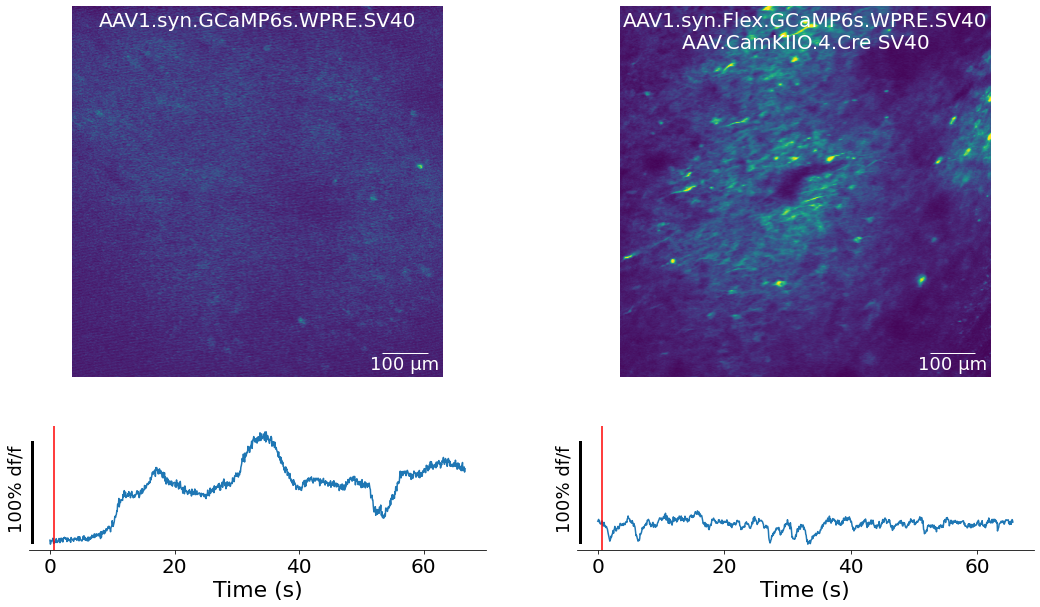

In [151]:
i_frame = 10
fontprops = fm.FontProperties(size=18)
#set up the figure

# height ratios:
# https://stackoverflow.com/questions/10388462/matplotlib-different-size-subplots
# update matplotlib, then height_ratios can be directly passed to subplots()!
fig, axs = plt.subplots(2, 2, figsize=(18,10), gridspec_kw={'height_ratios': [3, 1]}, sharey="row")
axs[0,0].axis('off')
axs[0,1].axis('off')
canvas_width, canvas_height = fig.canvas.get_width_height()

# 1.579 µm / pixel -> 100 µm = 63.33 pixels

scalebar1 = AnchoredSizeBar(axs[0,0].transData,
                           63.3, '100 µm', 'lower right', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)

scalebar2 = AnchoredSizeBar(axs[0,1].transData,
                           63.3, '100 µm', 'lower right', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)


axs[0,0].add_artist(scalebar1)
axs[0,1].add_artist(scalebar2)

# First frame
fig_left = axs[0, 0].imshow(ndarr_left[i_frame], ) #cmap="Greens_r"
ts_left = axs[1,0].plot(tstamps_left_zeroed_s, time_series_left_zeroed)
vline_left = axs[1,0].axvline(x=tstamps_left_zeroed_s[i_frame], color="red")


fig_right = axs[0, 1].imshow(ndarr_right[i_frame], )  #cmap="Greens_r"
ts_right = axs[1,1].plot(tstamps_right_zeroed_s, time_series_right_zeroed)
vline_right = axs[1, 1].axvline(x=tstamps_right_zeroed_s[i_frame], color="red")


axs[0,1].set_title('AAV1.syn.Flex.GCaMP6s.WPRE.SV40\nAAV.CamKIIO.4.Cre SV40', y=1.0, pad=-42, color="white", fontsize=20)
axs[0,0].set_title('AAV1.syn.GCaMP6s.WPRE.SV40', y=1.0, pad=-20, color="white", fontsize=20)

axs[1,0].set_xlabel("Time (s)", fontsize=22)
axs[1,0].tick_params(axis='x', labelsize=20)

axs[1,1].set_xlabel("Time (s)", fontsize=22)
axs[1,1].tick_params(axis='x', labelsize=20)

axs[1,0].set_ylabel("100% df/f", fontsize=18)
axs[1,1].set_ylabel("100% df/f", fontsize=18)
#axs[1,0].tick_params(axis='y', labelsize=20)

#axs[1,0].get_yaxis().set_visible(False)
#axs[1,1].get_yaxis().set_visible(False)
axs[1,0].get_yaxis().set_ticks([])
axs[1,1].get_yaxis().set_ticks([])
axs[1,0].spines['left'].set_visible(False)
axs[1,0].spines['right'].set_visible(False)
axs[1,0].spines['top'].set_visible(False)
axs[1,1].spines['left'].set_visible(False)
axs[1,1].spines['right'].set_visible(False)
axs[1,1].spines['top'].set_visible(False)
axs[1,0].add_patch(pyplot.Rectangle((-3,0),0.5, 1,facecolor='black',
                              clip_on=False,linewidth = 0))
axs[1,1].add_patch(pyplot.Rectangle((-3,0),0.5, 1,facecolor='black',
                              clip_on=False,linewidth = 0))

#plt.tight_layout()
plt.show()

# Set up parameters and function for video export

In [156]:
def testSubprocess():
    fontprops = fm.FontProperties(size=18)
    
    #set up the figure
    fig, axs = plt.subplots(2, 2, figsize=(18,16), gridspec_kw={'height_ratios': [3, 1]}, sharey="row")
    axs[0,0].axis('off')
    axs[0,1].axis('off')
    canvas_width, canvas_height = fig.canvas.get_width_height()

    
    scalebar1 = AnchoredSizeBar(axs[0,0].transData,
                           63.3, '100 µm', 'lower right', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)

    scalebar2 = AnchoredSizeBar(axs[0,1].transData,
                           63.3, '100 µm', 'lower right', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)
    
    axs[0,0].add_artist(scalebar1)
    axs[0,1].add_artist(scalebar2)
    
    # First frame
    fig_left = axs[0, 0].imshow(ndarr_left[0], ) # cmap="Greens_r"
    ts_left = axs[1,0].plot(tstamps_left_zeroed_s, time_series_left_zeroed)
    vline_left = axs[1,0].axvline(x=tstamps_left_zeroed_s[0], color="red")
    
    
    fig_right = axs[0, 1].imshow(ndarr_right[0], ) # cmap="Greens_r"
    ts_right = axs[1,1].plot(tstamps_right_zeroed_s, time_series_right_zeroed)
    vline_right = axs[1, 1].axvline(x=tstamps_right_zeroed_s[0], color="red")

    axs[0,1].set_title('AAV1.syn.Flex.GCaMP6s.WPRE.SV40\nAAV.CamKIIO.4.Cre SV40', y=1.0, pad=-42, color="white", fontsize=20)
    axs[0,0].set_title('AAV1.syn.GCaMP6s.WPRE.SV40', y=1.0, pad=-20, color="white", fontsize=20)

    axs[1,0].set_xlabel("Time (s)", fontsize=22)
    axs[1,0].tick_params(axis='x', labelsize=20)

    axs[1,1].set_xlabel("Time (s)", fontsize=22)
    axs[1,1].tick_params(axis='x', labelsize=20)

    axs[1,0].set_ylabel("100% df/f", fontsize=18)
    axs[1,1].set_ylabel("100% df/f", fontsize=18)
    #axs[1,0].tick_params(axis='y', labelsize=20)

    #axs[1,0].get_yaxis().set_visible(False)
    #axs[1,1].get_yaxis().set_visible(False)
    axs[1,0].get_yaxis().set_ticks([])
    axs[1,1].get_yaxis().set_ticks([])
    axs[1,0].spines['left'].set_visible(False)
    axs[1,0].spines['right'].set_visible(False)
    axs[1,0].spines['top'].set_visible(False)
    axs[1,1].spines['left'].set_visible(False)
    axs[1,1].spines['right'].set_visible(False)
    axs[1,1].spines['top'].set_visible(False)
    axs[1,0].add_patch(pyplot.Rectangle((-3,0),0.5, 1,facecolor='black',
                                  clip_on=False,linewidth = 0))
    axs[1,1].add_patch(pyplot.Rectangle((-3,0),0.5, 1,facecolor='black',
                                  clip_on=False,linewidth = 0))
    

    def update(frame):
        # your matplotlib code goes here
        fig_left.set_data(ndarr_left[frame])
        fig_right.set_data(ndarr_right[frame])
        vline_left.set_data([tstamps_left_zeroed_s[frame], tstamps_left_zeroed_s[frame]], [0, 1])
        vline_right.set_data([tstamps_right_zeroed_s[frame], tstamps_right_zeroed_s[frame]], [0, 1])

    # Open an ffmpeg process
    outf = "D:\\PhD\\Data\\testvid\\" + fh.get_filename_with_date("test_fast", ".mp4")
    print(outf)
    # lossless encoding:
    # https://stackoverflow.com/questions/37344997/how-to-get-a-lossless-encoding-with-ffmpeg-libx265
    cmdstring = ('ffmpeg', 
                 '-y', '-r', '15', # overwrite, 1fps
                 '-s', '%dx%d' % (canvas_width, canvas_height), # size of image string
                 '-pix_fmt', 'argb', # format
                 '-f', 'rawvideo',  '-i', '-', # tell ffmpeg to expect raw video from the pipe
                 #'-vcodec', 'mpeg4', outf) # use mpeg4 encoding
                 '-c:v', 'libx265',
                 '-x265-params', '"profile=monochrome12:crf=0:lossless=1:preset=veryslow:qp=0"',
                 outf)
    p = subprocess.Popen(cmdstring, stdin=subprocess.PIPE)

    # Draw frames and write to the pipe
    for frame in range(min(len(time_series_left), len(time_series_right))):
        print(frame)
        # draw the frame
        update(frame)
        fig.canvas.draw()

        # extract the image as an ARGB string
        string = fig.canvas.tostring_argb()
        
        # write to pipe
        p.stdin.write(string)

    # Finish up
    p.communicate()

D:\PhD\Data\testvid\test_fast_22-12-09_15-54-34.mp4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
26

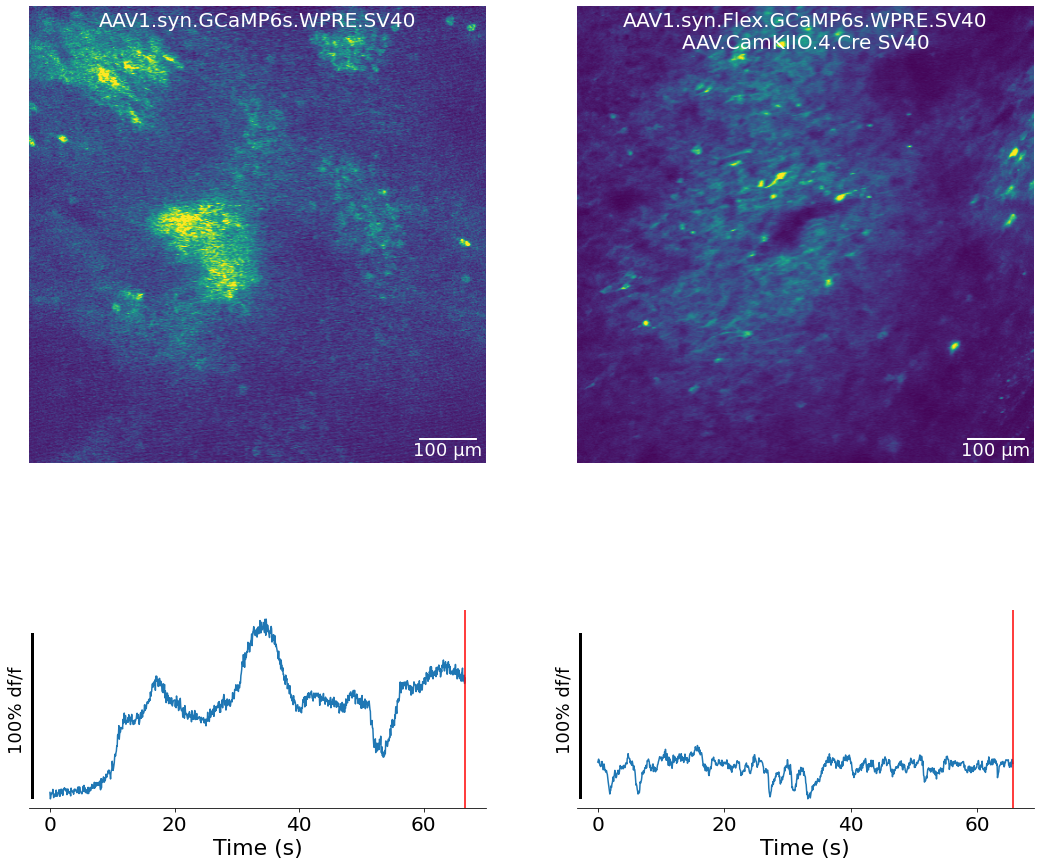

In [157]:
testSubprocess()

In [ ]:
ndarr_left

In [ ]:
import pims_nd2
nikfile_left = pims_nd2.ND2_Reader(video_left)

In [ ]:
nikfile_left.axes

In [ ]:
nikfile_left.iter_axes

In [ ]:
nikfile_left[1].metadata["t_ms"]

In [ ]:
np.zeros((1, 10))